In [1]:
import json 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from sedpy import observate

from astropy.cosmology import FlatLambdaCDM

In [2]:
# Load in the basic data
df = pd.read_csv("../data/all_basic_data.csv")

In [37]:
# Load in all spectra at a given redshift --> this may take some time
redshift_int = 6   # Or choose any of 10, 9, 8, 7, 6, 5, 4
redshift = 6.      # Or choose any of 10, 9, 8, 7, 6, 5, 4.64
f = open(f"../data/spectra/all_spec_z{redshift_int}.json")
dat = json.load(f)

In [38]:
# Print a header
df_z = df[df["redshift"]==redshift]
df_z.head(n=25)

,halo_id,redshift,x,y,z,mvir,rvir,stellar_mass,sfr_3,sfr_5,...,F277W_int,F300M_int,F335M_int,F356W_int,F360M_int,F410M_int,F430M_int,F444W_int,F460M_int,F480M_int
420,286,6.0,0.028753,0.164196,0.989784,9.655074,0.002542,7.77,0.06,0.20,...,29.277226,29.169111,28.829877,29.074223,28.957540,29.343774,29.353789,29.151054,28.574024,29.294040
421,997,6.0,0.188209,0.151902,0.017834,9.385045,0.002065,7.66,0.07,0.14,...,29.230379,29.162740,29.040788,29.235830,29.204413,29.506473,29.544033,29.331227,28.723660,29.555056
422,998,6.0,0.203132,0.141310,0.041008,10.419300,0.004575,8.57,0.40,0.54,...,27.970927,27.792123,27.504835,27.679204,27.578433,27.843038,27.845551,27.747330,27.420408,27.812654
423,4859,6.0,0.238442,0.238972,0.009321,9.782129,0.002802,7.88,0.59,0.51,...,29.285563,29.153752,28.539361,28.907862,28.711657,29.339969,29.338373,29.013256,28.225880,29.232658
424,5061,6.0,0.173879,0.165897,0.981873,10.173441,0.003784,8.52,0.54,0.78,...,27.954592,27.801054,27.464522,27.663522,27.552603,27.843273,27.837811,27.673145,27.186385,27.736968
425,5918,6.0,0.027583,0.242061,0.980855,10.155114,0.003732,8.12,1.35,0.97,...,28.600335,28.468606,27.806496,28.211895,27.972707,28.728097,28.739525,28.387700,27.552087,28.705977
426,6254,6.0,0.097892,0.374220,0.006785,9.163315,0.001742,6.88,0.57,0.56,...,29.958393,29.859593,29.115392,29.604846,29.391302,30.313825,30.333037,29.701578,28.564248,30.259343
427,7707,6.0,0.011688,0.525450,0.255492,9.700267,0.002631,7.84,6.71,5.11,...,27.669631,27.599474,26.367254,26.995818,26.577720,28.121062,28.140669,27.422594,26.217193,28.086575
428,9246,6.0,0.204004,0.375082,0.056984,9.343688,0.002004,7.33,0.13,0.12,...,29.553027,29.489012,29.150317,29.441545,29.344464,29.797056,29.814013,29.464480,28.637932,29.719693
429,9482,6.0,0.236701,0.531891,0.166199,10.447042,0.004670,8.90,1.36,1.36,...,26.996442,26.840436,26.422421,26.647623,26.496070,26.852840,26.849276,26.726586,26.338010,26.778941


## Example intrinsic spectrum at z=6

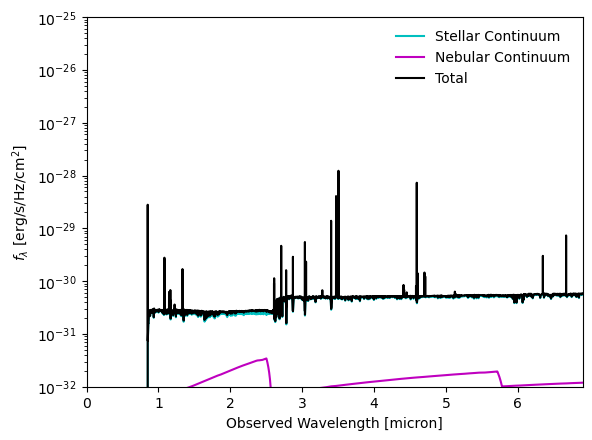

In [58]:
# For a some galaxy
halo_id = "26460"

# Plot the intrinsic stellar spectrum
plt.plot(
    dat[halo_id]["wavelengths"],
    10.**np.array(dat[halo_id]["intrinsic"]["stellar_continuum"]),
    c="c",label="Stellar Continuum")

# Plot the intrinsic nebular continuum
plt.plot(
    dat[halo_id]["wavelengths"],
    10.**np.array(dat[halo_id]["intrinsic"]["nebular_continuum"]),
    c="m",label="Nebular Continuum")

# Sum the nebular continuum, stellar continuum, and emission lines
plt.plot(
    dat[halo_id]["wavelengths"],
    10.**np.array(dat[halo_id]["intrinsic"]["total"]),
    c="k",label="Total")

plt.yscale("log")
plt.xscale("linear")
plt.ylim(1e-32,1e-25)
plt.xlim(0,6.9)

plt.xlabel("Observed Wavelength [micron]")
plt.ylabel(r"$f_{\lambda}\ {\rm [erg/s/Hz/cm^2]}$")
plt.legend(loc=1,frameon=False)

### Plot the spectra against the JWST filter magnitudes

In [59]:
# List of relevant JWST filters
all_filts = [
 'jwst_f070w',
 'jwst_f090w',
 'jwst_f115w',
 'jwst_f140m',
 'jwst_f150w',
 'jwst_f162m',
 'jwst_f182m',
 'jwst_f200w',
 'jwst_f210m',
 'jwst_f250m',
 'jwst_f277w',
 'jwst_f300m',
 'jwst_f335m',
 'jwst_f356w',
 'jwst_f360m',
 'jwst_f410m',
 'jwst_f430m',
 'jwst_f444w',
 'jwst_f460m',
 'jwst_f480m',
]
wave_dw = np.array([observate.Filter(i).effective_width for i in all_filts])/1e4
wave_w  = np.array([observate.Filter(i).wave_mean for i in all_filts])/1e4

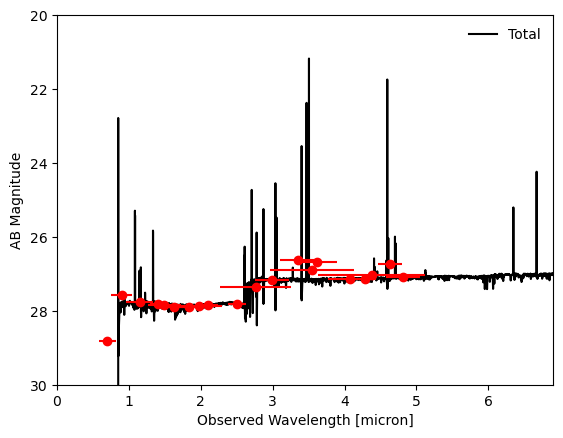

In [60]:
# Get the JWST filter magnitudes for the galaxy
all_mags = np.zeros(len(all_filts))
for i,key in enumerate(all_filts):
    jwst_filt = key.split("_")[-1].upper()
    new_key = f"{jwst_filt}_int"
    all_mags[i] = float(df[df["halo_id"]==int(halo_id)][new_key])

# Plot the total intrinsic spectrum 
plt.plot(
    dat[halo_id]["wavelengths"],
    -2.5 * np.log10(10.**np.array(dat[halo_id]["intrinsic"]["total"])/(1e-23 * 3631.)),
    c="k",label="Total")

# Plot the filter magnitudes
plt.errorbar(wave_w,all_mags,xerr=wave_dw,fmt="o",color="r")

plt.yscale("linear")
plt.xscale("linear")
plt.xlim(0,6.9)
plt.ylim(30,20)
plt.xlabel("Observed Wavelength [micron]")
plt.ylabel("AB Magnitude")
plt.legend(loc=1,frameon=False)

## Example dust attenuated spectrum at z=6

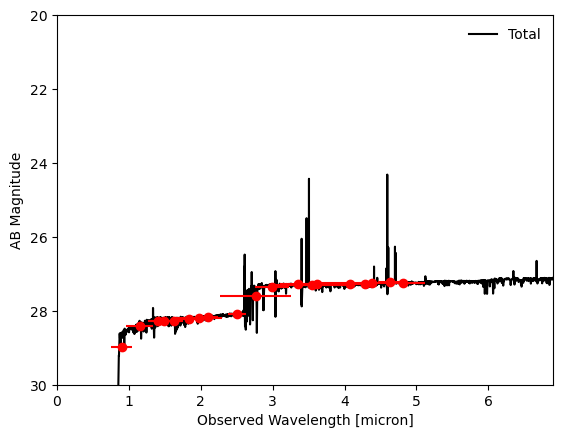

In [61]:
# For a typical galaxy
direction = 1 # Change this from 0-9 to see other directions

# Get the JWST filter magnitudes for the galaxy
all_mags = np.zeros(len(all_filts))
for i,key in enumerate(all_filts):
    jwst_filt = key.split("_")[-1].upper()
    new_key = f"{jwst_filt}_dir_{direction}"
    all_mags[i] = float(df[df["halo_id"]==int(halo_id)][new_key])

# Plot the total intrinsic spectrum 
plt.plot(
    dat[halo_id]["wavelengths"],
    -2.5 * np.log10(10.**np.array(dat[halo_id][f"dir_{direction}"]["total"])/(1e-23 * 3631.)),
    c="k",label="Total")

# Plot the filter magnitudes
plt.errorbar(wave_w,all_mags,xerr=wave_dw,fmt="o",color="r")

plt.yscale("linear")
plt.xscale("linear")
plt.xlim(0,6.9)
plt.ylim(30,20)
plt.xlabel("Observed Wavelength [micron]")
plt.ylabel("AB Magnitude")
plt.legend(loc=1,frameon=False)